In [1]:
import json
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any, Tuple, Optional
from dataclasses import dataclass
from datetime import datetime
import re
import sys
import os

from ragas import evaluate
from ragas.metrics import (
    answer_relevancy, faithfulness, context_precision, context_recall
)

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
@dataclass
class EvaluationResult:
    """Single evaluation result."""
    query: str
    expected_answer: Optional[str]
    retrieved_sources: List[Dict]
    generated_answer: str
    retrieval_time: float
    generation_time: float
    
    # Metrics
    retrieval_precision: float = 0.0
    retrieval_recall: float = 0.0
    retrieval_relevance: float = 0.0
    answer_relevance: float = 0.0
    answer_factuality: float = 0.0
    answer_completeness: float = 0.0
    source_citation: float = 0.0


@dataclass
class BenchmarkQuestion:
    """Benchmark question with expected answers."""
    query: str
    expected_sections: List[str]
    expected_keywords: List[str]
    difficulty: str  # easy, medium, hard
    question_type: str  # factual, descriptive, comparative, analytical
    expected_answer: Optional[str] = None

In [3]:
class FranceGeographyBenchmark:
    """Benchmark dataset for France geography questions."""
    
    def __init__(self):
        self.questions = self._create_benchmark_questions()
    
    def _create_benchmark_questions(self) -> List[BenchmarkQuestion]:
        """Create comprehensive benchmark questions."""
        return [
            # Easy factual questions
            BenchmarkQuestion(
                query="What are the main mountain ranges in France?",
                expected_sections=["Land", "The younger mountains"],
                expected_keywords=["Alps", "Pyrenees", "Massif Central", "Vosges"],
                difficulty="easy",
                question_type="factual"
            ),
            BenchmarkQuestion(
                query="What is the climate like in France?",
                expected_sections=["Climate"],
                expected_keywords=["temperate", "oceanic", "Mediterranean", "continental"],
                difficulty="easy",
                question_type="descriptive"
            ),
            BenchmarkQuestion(
                query="What are the major rivers in France?",
                expected_sections=["Drainage"],
                expected_keywords=["Seine", "Loire", "Rhône", "Garonne"],
                difficulty="easy",
                question_type="factual"
            ),
            
            # Medium difficulty questions
            BenchmarkQuestion(
                query="How do the Hercynian massifs differ from the younger mountains?",
                expected_sections=["The Hercynian massifs", "The younger mountains"],
                expected_keywords=["Hercynian", "Alps", "Pyrenees", "older", "younger"],
                difficulty="medium",
                question_type="comparative"
            ),
            BenchmarkQuestion(
                query="Describe the soil types found in different regions of France",
                expected_sections=["Soils"],
                expected_keywords=["alluvial", "limestone", "clay", "sandy"],
                difficulty="medium",
                question_type="descriptive"
            ),
            BenchmarkQuestion(
                query="What wildlife can be found in France?",
                expected_sections=["Plant and animal life"],
                expected_keywords=["forests", "wildlife", "fauna", "flora"],
                difficulty="medium",
                question_type="descriptive"
            ),
            
            # Hard analytical questions
            BenchmarkQuestion(
                query="How do geographic features influence France's climate patterns?",
                expected_sections=["Climate", "Land", "The younger mountains"],
                expected_keywords=["geographic", "altitude", "maritime", "continental"],
                difficulty="hard",
                question_type="analytical"
            ),
            BenchmarkQuestion(
                query="Analyze the relationship between topography and drainage patterns in France",
                expected_sections=["Drainage", "Land", "The great lowlands"],
                expected_keywords=["topography", "drainage", "watershed", "elevation"],
                difficulty="hard",
                question_type="analytical"
            ),
            BenchmarkQuestion(
                query="What are the environmental and agricultural implications of France's soil diversity?",
                expected_sections=["Soils", "Plant and animal life"],
                expected_keywords=["soil", "agriculture", "environmental", "diversity"],
                difficulty="hard",
                question_type="analytical"
            ),
            
            # Specific detailed questions
            BenchmarkQuestion(
                query="Describe the characteristics of the Paris Basin",
                expected_sections=["The great lowlands"],
                expected_keywords=["Paris Basin", "sedimentary", "lowlands"],
                difficulty="medium",
                question_type="descriptive"
            ),
            BenchmarkQuestion(
                query="What are the key features of the Massif Central?",
                expected_sections=["The Hercynian massifs"],
                expected_keywords=["Massif Central", "volcanic", "plateau"],
                difficulty="medium",
                question_type="descriptive"
            )
        ]
    
    def get_questions_by_difficulty(self, difficulty: str) -> List[BenchmarkQuestion]:
        """Get questions by difficulty level."""
        return [q for q in self.questions if q.difficulty == difficulty]
    
    def get_questions_by_type(self, question_type: str) -> List[BenchmarkQuestion]:
        """Get questions by type."""
        return [q for q in self.questions if q.question_type == question_type]

In [4]:
class RAGEvaluator:
    """Comprehensive RAG system evaluator."""
    
    def __init__(self, api_base_url: str = "http://localhost:8000"):
        self.api_base_url = api_base_url
        self.benchmark = FranceGeographyBenchmark()
        self.evaluation_results = []
        
    def _make_api_request(self, endpoint: str, data: Dict = None, timeout: int = 30) -> Dict:
        """Make API request with error handling."""
        try:
            if data:
                response = requests.post(f"{self.api_base_url}{endpoint}", json=data, timeout=timeout)
            else:
                response = requests.get(f"{self.api_base_url}{endpoint}", timeout=timeout)
            
            response.raise_for_status()
            return response.json()
        
        except requests.exceptions.ConnectionError:
            raise Exception(f"Cannot connect to API at {self.api_base_url}. Is the server running?")
        except requests.exceptions.Timeout:
            raise Exception(f"Request timeout after {timeout} seconds")
        except requests.exceptions.HTTPError as e:
            raise Exception(f"HTTP error {response.status_code}: {response.text}")
    
    def evaluate_retrieval(self, query: str, k: int = 5) -> Tuple[List[Dict], float, Dict]:
        """Evaluate retrieval performance for a single query."""
        start_time = time.time()
        
        # Make retrieval request
        response = self._make_api_request("/retrieve", {
            "query": query,
            "k": k
        })
        
        retrieval_time = time.time() - start_time
        sources = response.get("sources", [])
        
        metrics = {
            "num_sources": len(sources),
            "avg_score": np.mean([s["score"] for s in sources]) if sources else 0.0,
            "min_score": min([s["score"] for s in sources]) if sources else 0.0,
            "max_score": max([s["score"] for s in sources]) if sources else 0.0,
            "retrieval_time": retrieval_time
        }
        
        return sources, retrieval_time, metrics
    
    def evaluate_generation(self, query: str, k: int = 5, **kwargs) -> Tuple[str, List[Dict], float, Dict]:
        """Evaluate generation performance for a single query."""
        start_time = time.time()
        
        # Make generation request
        request_data = {
            "query": query,
            "k": k,
            **kwargs
        }
        
        response = self._make_api_request("/generate", request_data, timeout=60)
        
        generation_time = time.time() - start_time
        answer = response.get("answer", "")
        sources = response.get("sources", [])
        metadata = response.get("metadata", {})
        
        metrics = {
            "answer_length": len(answer),
            "num_sources_used": len(sources),
            "generation_time": generation_time,
            "token_usage": metadata.get("token_usage", {})
        }
        
        return answer, sources, generation_time, metrics
    
    def calculate_retrieval_relevance(self, sources: List[Dict], expected_sections: List[str]) -> float:
        """Calculate retrieval relevance based on expected sections."""
        if not sources or not expected_sections:
            return 0.0
        
        relevant_sources = 0
        for source in sources:
            if any(exp.lower() in source.get("section", "").lower() for exp in expected_sections):
                relevant_sources += 1
        
        return relevant_sources / len(sources)
    
    def calculate_keyword_coverage(self, text: str, expected_keywords: List[str]) -> float:
        """Calculate how many expected keywords are covered in the text."""
        if not expected_keywords:
            return 1.0
        
        text_lower = text.lower()
        covered_keywords = sum(1 for keyword in expected_keywords 
                             if keyword.lower() in text_lower)
        
        return covered_keywords / len(expected_keywords)
    
    def calculate_answer_quality_metrics(self, answer: str, query: str, sources: List[Dict]) -> Dict[str, float]:
        """Calculate various answer quality metrics."""
        metrics = {}
        
        # Answer length appropriateness (not too short, not too long)
        answer_length = len(answer)
        if answer_length < 100:
            metrics["length_score"] = answer_length / 100  # Penalty for short answers
        elif answer_length > 2000:
            metrics["length_score"] = max(0.5, 1.0 - (answer_length - 2000) / 1000)  # Penalty for very long answers
        else:
            metrics["length_score"] = 1.0
        
        # Source citation (does the answer reference sources?)
        citation_indicators = ["according to", "based on", "the text mentions", "as stated", "source"]
        has_citations = any(indicator in answer.lower() for indicator in citation_indicators)
        metrics["source_citation"] = 1.0 if has_citations else 0.0
        
        # Coherence (basic check for well-formed sentences)
        sentences = answer.split('.')
        complete_sentences = sum(1 for s in sentences if len(s.strip()) > 10 and ' ' in s.strip())
        metrics["coherence"] = min(1.0, complete_sentences / max(1, len(sentences) - 1))
        
        # Information density (ratio of content words to total words)
        words = answer.split()
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should'}
        content_words = sum(1 for word in words if word.lower() not in stop_words)
        metrics["information_density"] = content_words / max(1, len(words))
        
        return metrics
    
    def evaluate_single_question(self, question: BenchmarkQuestion, k: int = 5) -> EvaluationResult:
        """Evaluate a single benchmark question."""
        print(f"🔍 Evaluating: {question.query[:60]}...")
        
        # Evaluate retrieval
        sources, retrieval_time, retrieval_metrics = self.evaluate_retrieval(question.query, k)
        
        # Evaluate generation
        answer, gen_sources, generation_time, gen_metrics = self.evaluate_generation(question.query, k)
        
        # Calculate relevance metrics
        retrieval_relevance = self.calculate_retrieval_relevance(sources, question.expected_sections)
        keyword_coverage = self.calculate_keyword_coverage(answer, question.expected_keywords)
        
        # Calculate answer quality metrics
        quality_metrics = self.calculate_answer_quality_metrics(answer, question.query, gen_sources)
        
        # Create evaluation result
        result = EvaluationResult(
            query=question.query,
            expected_answer=question.expected_answer,
            retrieved_sources=sources,
            generated_answer=answer,
            retrieval_time=retrieval_time,
            generation_time=generation_time,
            retrieval_relevance=retrieval_relevance,
            answer_relevance=keyword_coverage,
            answer_factuality=quality_metrics.get("information_density", 0.0),
            answer_completeness=quality_metrics.get("length_score", 0.0),
            source_citation=quality_metrics.get("source_citation", 0.0)
        )
        
        return result
    
    def run_benchmark_evaluation(self, difficulties: List[str] = None, k: int = 5) -> List[EvaluationResult]:
        """Run evaluation on benchmark questions."""
        if difficulties is None:
            difficulties = ["easy", "medium", "hard"]
        
        print(f"\n🧪 RUNNING BENCHMARK EVALUATION")
        print(f"📊 Difficulties: {difficulties}")
        print(f"🔍 Top-k sources: {k}")
        print("=" * 60)
        
        results = []
        
        for difficulty in difficulties:
            questions = self.benchmark.get_questions_by_difficulty(difficulty)
            print(f"\n📋 Evaluating {difficulty.upper()} questions ({len(questions)} total):")
            
            for i, question in enumerate(questions):
                try:
                    result = self.evaluate_single_question(question, k)
                    results.append(result)
                    
                    # Show brief result
                    print(f"  {i+1:2d}. ✅ Score: {result.retrieval_relevance:.2f} | "
                          f"Time: {result.generation_time:.1f}s")
                    
                except Exception as e:
                    print(f"  {i+1:2d}. ❌ Error: {str(e)}")
                    continue
                
                # Small delay to be respectful to the API
                time.sleep(0.5)
        
        self.evaluation_results.extend(results)
        print(f"\n✅ Evaluation complete! {len(results)} questions evaluated.")
        
        return results
    
    def calculate_aggregate_metrics(self, results: List[EvaluationResult]) -> Dict[str, Any]:
        """Calculate aggregate metrics across all results."""
        if not results:
            return {}
        
        metrics = {
            "total_questions": len(results),
            "avg_retrieval_time": np.mean([r.retrieval_time for r in results]),
            "avg_generation_time": np.mean([r.generation_time for r in results]),
            "avg_total_time": np.mean([r.retrieval_time + r.generation_time for r in results]),
            "avg_retrieval_relevance": np.mean([r.retrieval_relevance for r in results]),
            "avg_answer_relevance": np.mean([r.answer_relevance for r in results]),
            "avg_answer_factuality": np.mean([r.answer_factuality for r in results]),
            "avg_answer_completeness": np.mean([r.answer_completeness for r in results]),
            "avg_source_citation": np.mean([r.source_citation for r in results]),
            "std_retrieval_time": np.std([r.retrieval_time for r in results]),
            "std_generation_time": np.std([r.generation_time for r in results])
        }
        
        # Calculate overall score - FIXED VERSION
        # Remove the unused quality_scores variable and simplify the calculation
        metrics["overall_score"] = np.mean([
            np.mean([
                r.retrieval_relevance,
                r.answer_relevance, 
                r.answer_factuality,
                r.answer_completeness,
                r.source_citation
            ]) for r in results
        ])
        
        return metrics
    
    def generate_evaluation_report(self, results: List[EvaluationResult],  output_dir: str = "../docs") -> None:
        """Generate comprehensive evaluation report."""
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True)
        
        # Calculate metrics
        metrics = self.calculate_aggregate_metrics(results)
        
        # Create visualizations
        self._create_evaluation_plots(results, output_dir)
        
        # Generate detailed report
        report = {
            "evaluation_timestamp": datetime.now().isoformat(),
            "system_info": {
                "api_base_url": self.api_base_url,
                "total_questions": len(results)
            },
            "aggregate_metrics": metrics,
            "detailed_results": []
        }
        
        # Add detailed results
        for result in results:
            report["detailed_results"].append({
                "query": result.query,
                "retrieval_time": result.retrieval_time,
                "generation_time": result.generation_time,
                "retrieval_relevance": result.retrieval_relevance,
                "answer_relevance": result.answer_relevance,
                "answer_factuality": result.answer_factuality,
                "answer_completeness": result.answer_completeness,
                "source_citation": result.source_citation,
                "num_sources": len(result.retrieved_sources),
                "answer_length": len(result.generated_answer)
            })
        
        # Save JSON report
        report_file = output_dir / "evaluation_report.json"
        with open(report_file, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        
        # Generate markdown summary
        self._generate_markdown_report(metrics, results, output_dir)
        
        print(f"📊 Evaluation report saved to: {report_file}")
        print(f"📋 Summary saved to: {output_dir / 'evaluation_summary.md'}")
    
    def _create_evaluation_plots(self, results: List[EvaluationResult], output_dir: Path) -> None:
        """Create evaluation visualizations."""
        if not results:
            return
        
        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('RAG System Evaluation Results', fontsize=16, fontweight='bold')
        
        # 1. Performance times
        retrieval_times = [r.retrieval_time for r in results]
        generation_times = [r.generation_time for r in results]
        
        axes[0, 0].hist([retrieval_times, generation_times], 
                       label=['Retrieval', 'Generation'], alpha=0.7, bins=10)
        axes[0, 0].set_xlabel('Time (seconds)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Performance Distribution')
        axes[0, 0].legend()
        
        # 2. Quality metrics radar chart (using bar chart instead)
        metrics = ['Retrieval\nRelevance', 'Answer\nRelevance', 'Answer\nFactuality', 
                  'Answer\nCompleteness', 'Source\nCitation']
        values = [
            np.mean([r.retrieval_relevance for r in results]),
            np.mean([r.answer_relevance for r in results]),
            np.mean([r.answer_factuality for r in results]),
            np.mean([r.answer_completeness for r in results]),
            np.mean([r.source_citation for r in results])
        ]
        
        bars = axes[0, 1].bar(metrics, values, color=sns.color_palette("husl", len(metrics)))
        axes[0, 1].set_ylim(0, 1)
        axes[0, 1].set_title('Average Quality Metrics')
        axes[0, 1].set_ylabel('Score (0-1)')
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                           f'{value:.2f}', ha='center', va='bottom')
        
        # 3. Time vs Quality scatter
        total_times = [r.retrieval_time + r.generation_time for r in results]
        overall_quality = [(r.retrieval_relevance + r.answer_relevance + r.answer_factuality + 
                          r.answer_completeness + r.source_citation) / 5 for r in results]
        
        axes[0, 2].scatter(total_times, overall_quality, alpha=0.6)
        axes[0, 2].set_xlabel('Total Time (seconds)')
        axes[0, 2].set_ylabel('Overall Quality Score')
        axes[0, 2].set_title('Time vs Quality Trade-off')
        
        # 4. Source utilization
        num_sources = [len(r.retrieved_sources) for r in results]
        axes[1, 0].hist(num_sources, bins=range(1, max(num_sources) + 2), alpha=0.7)
        axes[1, 0].set_xlabel('Number of Sources Retrieved')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Source Utilization Distribution')
        
        # 5. Answer length distribution
        answer_lengths = [len(r.generated_answer) for r in results]
        axes[1, 1].hist(answer_lengths, bins=15, alpha=0.7, color='orange')
        axes[1, 1].set_xlabel('Answer Length (characters)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Answer Length Distribution')
        
        # 6. Quality score distribution
        axes[1, 2].hist(overall_quality, bins=10, alpha=0.7, color='green')
        axes[1, 2].set_xlabel('Overall Quality Score')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Quality Score Distribution')
        
        plt.tight_layout()
        plot_file = output_dir / "evaluation_plots.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"📈 Evaluation plots saved to: {plot_file}")
    
    def _generate_markdown_report(self, metrics: Dict, results: List[EvaluationResult], 
                                output_dir: Path) -> None:
        """Generate markdown evaluation summary."""
        summary_file = output_dir / "evaluation_summary.md"
        
        with open(summary_file, 'w', encoding='utf-8') as f:
            f.write("# RAG System Evaluation Report\n\n")
            f.write(f"**Generated:** {datetime.now().isoformat()}\n")
            f.write(f"**Questions Evaluated:** {metrics.get('total_questions', 0)}\n\n")
            
            # Overall Performance
            f.write("## 🎯 Overall Performance\n\n")
            overall_score = metrics.get('overall_score', 0)
            if overall_score >= 0.8:
                status = "🏆 EXCELLENT"
            elif overall_score >= 0.6:
                status = "✅ GOOD"
            elif overall_score >= 0.4:
                status = "⚠️ FAIR"
            else:
                status = "❌ NEEDS IMPROVEMENT"
            
            f.write(f"**Overall Score:** {overall_score:.3f} - {status}\n\n")
            
            # Key Metrics
            f.write("## 📊 Key Metrics\n\n")
            f.write("| Metric | Score | Status |\n")
            f.write("|--------|-------|--------|\n")
            
            metric_definitions = [
                ("Retrieval Relevance", "avg_retrieval_relevance", "How well retrieved sources match the query"),
                ("Answer Relevance", "avg_answer_relevance", "How relevant the answer is to the question"),
                ("Answer Factuality", "avg_answer_factuality", "Information density and factual content"),
                ("Answer Completeness", "avg_answer_completeness", "Appropriate length and coverage"),
                ("Source Citation", "avg_source_citation", "How well the answer cites sources")
            ]
            
            for name, key, description in metric_definitions:
                value = metrics.get(key, 0)
                if value >= 0.8:
                    status_icon = "🏆"
                elif value >= 0.6:
                    status_icon = "✅"
                elif value >= 0.4:
                    status_icon = "⚠️"
                else:
                    status_icon = "❌"
                
                f.write(f"| {name} | {value:.3f} | {status_icon} |\n")
            
            # Performance Metrics
            f.write(f"\n## ⚡ Performance Metrics\n\n")
            f.write(f"- **Average Retrieval Time:** {metrics.get('avg_retrieval_time', 0):.2f}s\n")
            f.write(f"- **Average Generation Time:** {metrics.get('avg_generation_time', 0):.2f}s\n")
            f.write(f"- **Average Total Time:** {metrics.get('avg_total_time', 0):.2f}s\n")
            
            # Recommendations
            f.write(f"\n## 💡 Recommendations\n\n")
            
            recommendations = []
            if metrics.get('avg_retrieval_relevance', 0) < 0.6:
                recommendations.append("🔍 Improve retrieval by tuning embedding model or chunking strategy")
            if metrics.get('avg_source_citation', 0) < 0.5:
                recommendations.append("📝 Enhance prompts to encourage better source citation")
            if metrics.get('avg_generation_time', 0) > 5.0:
                recommendations.append("⚡ Consider optimizing generation parameters for faster response")
            if metrics.get('avg_answer_completeness', 0) < 0.6:
                recommendations.append("📏 Adjust max_tokens or improve answer length optimization")
            
            if not recommendations:
                recommendations.append("🎉 System performance is excellent! Consider testing with more diverse queries.")
            
            for rec in recommendations:
                f.write(f"- {rec}\n")

In [5]:
def run_performance_stress_test(evaluator: RAGEvaluator, num_concurrent: int = 5, 
                               total_requests: int = 20) -> Dict[str, Any]:
    """Run stress test to evaluate system under load."""
    print(f"\n⚡ RUNNING PERFORMANCE STRESS TEST")
    print(f"📊 Concurrent requests: {num_concurrent}")
    print(f"📊 Total requests: {total_requests}")
    print("=" * 50)
    
    import concurrent.futures
    import threading
    
    test_queries = [
        "What are the main mountain ranges in France?",
        "Describe France's climate patterns",
        "What rivers flow through France?",
        "Tell me about French soil types",
        "What wildlife is found in France?"
    ]
    
    results = []
    errors = []
    lock = threading.Lock()
    
    def make_request(query_id: int) -> Dict:
        """Make a single request and measure performance."""
        query = test_queries[query_id % len(test_queries)]
        
        try:
            start_time = time.time()
            
            # Make generation request
            response = evaluator._make_api_request("/generate", {
                "query": f"{query} (request {query_id})",
                "k": 3,
                "max_tokens": 200
            })
            
            end_time = time.time()
            
            with lock:
                results.append({
                    "query_id": query_id,
                    "response_time": end_time - start_time,
                    "answer_length": len(response.get("answer", "")),
                    "num_sources": len(response.get("sources", [])),
                    "success": True
                })
            
            return {"success": True, "time": end_time - start_time}
            
        except Exception as e:
            with lock:
                errors.append({"query_id": query_id, "error": str(e)})
            return {"success": False, "error": str(e)}
    
    # Run concurrent requests
    start_time = time.time()
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_concurrent) as executor:
        futures = [executor.submit(make_request, i) for i in range(total_requests)]
        
        # Process results as they complete
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            result = future.result()
            print(f"  Request {i+1:2d}/{total_requests}: "
                  f"{'✅' if result['success'] else '❌'} "
                  f"{result.get('time', 0):.2f}s")
    
    total_time = time.time() - start_time
    
    # Calculate metrics
    successful_requests = len(results)
    failed_requests = len(errors)
    
    if successful_requests > 0:
        avg_response_time = np.mean([r["response_time"] for r in results])
        min_response_time = min([r["response_time"] for r in results])
        max_response_time = max([r["response_time"] for r in results])
        throughput = successful_requests / total_time
    else:
        avg_response_time = min_response_time = max_response_time = throughput = 0
    
    stress_metrics = {
        "total_requests": total_requests,
        "successful_requests": successful_requests,
        "failed_requests": failed_requests,
        "success_rate": successful_requests / total_requests,
        "total_time": total_time,
        "avg_response_time": avg_response_time,
        "min_response_time": min_response_time,
        "max_response_time": max_response_time,
        "throughput_rps": throughput,
        "concurrent_users": num_concurrent
    }
    
    print(f"\n📊 Stress Test Results:")
    print(f"  Success Rate: {stress_metrics['success_rate']:.1%}")
    print(f"  Average Response Time: {avg_response_time:.2f}s")
    print(f"  Throughput: {throughput:.1f} requests/second")
    print(f"  Failed Requests: {failed_requests}")
    
    return stress_metrics


In [6]:
print("=" * 70)
print("🧪 FRANCE RAG SYSTEM - COMPREHENSIVE EVALUATION")
print("=" * 70)

# Initialize evaluator
api_url = "http://localhost:8000"
evaluator = RAGEvaluator(api_url)

# Check API connection
try:
    health = evaluator._make_api_request("/health")
    if health.get("status") != "healthy":
        print(f"⚠️ API health check failed: {health}")
    print(f"✅ Connected to API at {api_url}")
except Exception as e:
    print(f"❌ Cannot connect to API: {e}")
    print("💡 Make sure the API server is running: python scripts/run_api.py")

🧪 FRANCE RAG SYSTEM - COMPREHENSIVE EVALUATION
⚠️ API health check failed: {'status': 'unhealthy', 'timestamp': '2025-07-17T12:22:56.696776', 'components': {'api': 'healthy', 'rag_system': 'healthy', 'retrieval': 'healthy', 'embedding_model': 'sentence-transformers/all-MiniLM-L6-v2', 'generation_model': 'meta-llama/Llama-3.3-70B-Instruct-Turbo-Free'}}
✅ Connected to API at http://localhost:8000


In [7]:
print(f"\n📋 Running benchmark evaluation...")
results = evaluator.run_benchmark_evaluation(k=5)

if not results:
    print("❌ No evaluation results obtained!")


📋 Running benchmark evaluation...

🧪 RUNNING BENCHMARK EVALUATION
📊 Difficulties: ['easy', 'medium', 'hard']
🔍 Top-k sources: 5

📋 Evaluating EASY questions (3 total):
🔍 Evaluating: What are the main mountain ranges in France?...
   1. ✅ Score: 0.60 | Time: 19.9s
🔍 Evaluating: What is the climate like in France?...
   2. ✅ Score: 0.80 | Time: 30.0s
🔍 Evaluating: What are the major rivers in France?...
   3. ✅ Score: 1.00 | Time: 39.7s

📋 Evaluating MEDIUM questions (5 total):
🔍 Evaluating: How do the Hercynian massifs differ from the younger mountai...
   1. ✅ Score: 0.80 | Time: 41.2s
🔍 Evaluating: Describe the soil types found in different regions of France...
   2. ✅ Score: 0.20 | Time: 31.0s
🔍 Evaluating: What wildlife can be found in France?...
   3. ✅ Score: 0.80 | Time: 6.0s
🔍 Evaluating: Describe the characteristics of the Paris Basin...
   4. ✅ Score: 0.80 | Time: 2.4s
🔍 Evaluating: What are the key features of the Massif Central?...
   5. ✅ Score: 0.60 | Time: 16.9s

📋 Evalu

In [8]:
# Calculate and display aggregate metrics
metrics = evaluator.calculate_aggregate_metrics(results)

print(f"\n📊 EVALUATION SUMMARY:")
print(f"  Questions evaluated: {metrics['total_questions']}")
print(f"  Overall score: {metrics['overall_score']:.3f}")
print(f"  Retrieval relevance: {metrics['avg_retrieval_relevance']:.3f}")
print(f"  Answer quality: {metrics['avg_answer_relevance']:.3f}")
print(f"  Average response time: {metrics['avg_total_time']:.2f}s")


📊 EVALUATION SUMMARY:
  Questions evaluated: 11
  Overall score: 0.749
  Retrieval relevance: 0.691
  Answer quality: 0.621
  Average response time: 23.62s


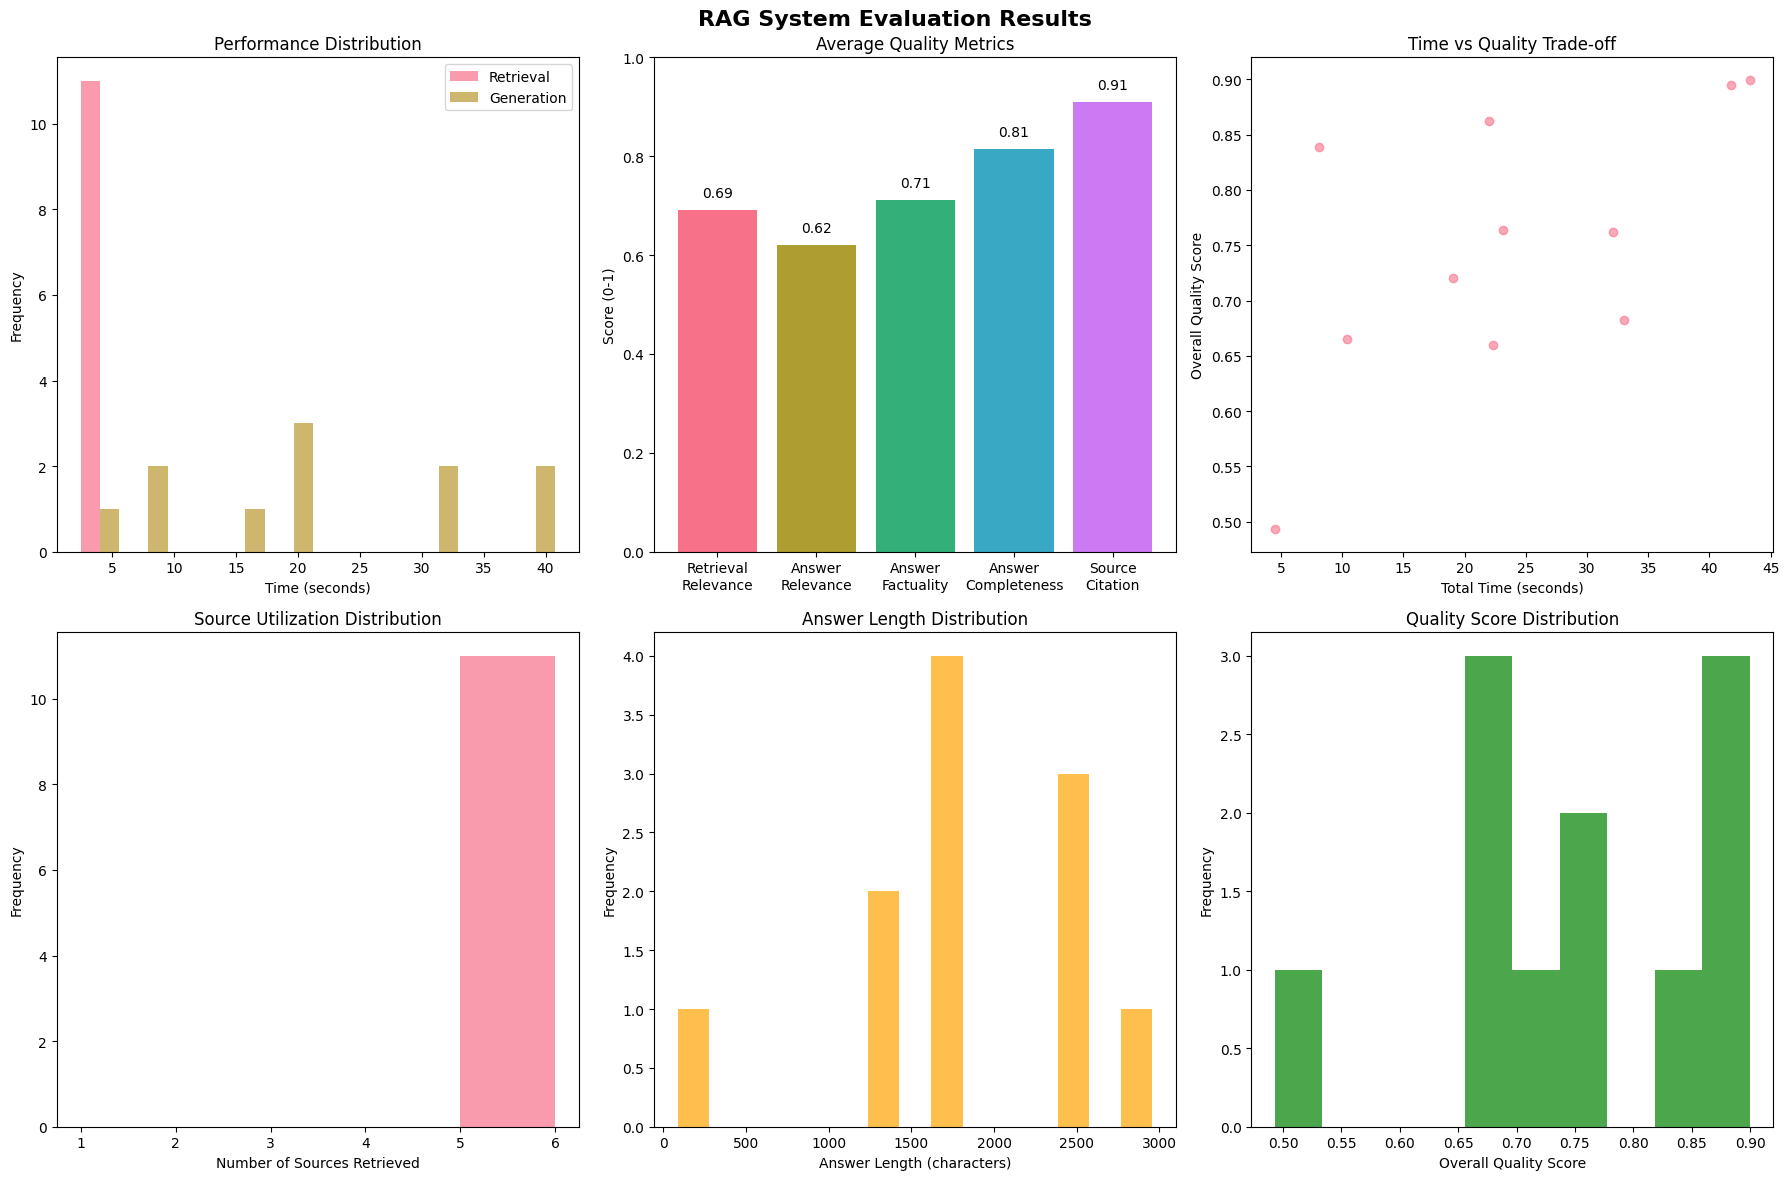

📈 Evaluation plots saved to: ..\docs\evaluation_plots.png
📊 Evaluation report saved to: ..\docs\evaluation_report.json
📋 Summary saved to: ..\docs\evaluation_summary.md


In [9]:
# Generate comprehensive report
evaluator.generate_evaluation_report(results)

In [10]:
# Run stress test
if input("\n🔥 Run performance stress test? (y/n): ").lower() == 'y':
    stress_metrics = run_performance_stress_test(evaluator)
    
    # Save stress test results
    output_dir = Path("../docs")
    stress_file = output_dir / "stress_test_results.json"
    with open(stress_file, 'w') as f:
        json.dump(stress_metrics, f, indent=2)
    print(f"💾 Stress test results saved to: {stress_file}")

print(f"\n🎉 EVALUATION COMPLETE!")
print(f"📊 Reports saved to: ../docs/")
print(f"📈 Check evaluation_plots.png for visualizations")


⚡ RUNNING PERFORMANCE STRESS TEST
📊 Concurrent requests: 5
📊 Total requests: 20
  Request  1/20: ✅ 6.32s
  Request  2/20: ✅ 7.24s
  Request  3/20: ✅ 7.24s
  Request  4/20: ✅ 7.23s
  Request  5/20: ✅ 13.48s
  Request  6/20: ✅ 10.65s
  Request  7/20: ✅ 11.57s
  Request  8/20: ✅ 10.65s
  Request  9/20: ✅ 10.65s
  Request 10/20: ✅ 4.71s
  Request 11/20: ✅ 5.64s
  Request 12/20: ✅ 5.65s
  Request 13/20: ✅ 5.65s
  Request 14/20: ✅ 6.35s
  Request 15/20: ✅ 6.05s
  Request 16/20: ✅ 2.44s
  Request 17/20: ✅ 3.26s
  Request 18/20: ✅ 3.26s
  Request 19/20: ✅ 4.65s
  Request 20/20: ✅ 4.65s

📊 Stress Test Results:
  Success Rate: 100.0%
  Average Response Time: 6.87s
  Throughput: 0.7 requests/second
  Failed Requests: 0
💾 Stress test results saved to: ..\docs\stress_test_results.json

🎉 EVALUATION COMPLETE!
📊 Reports saved to: ../docs/
📈 Check evaluation_plots.png for visualizations


In [11]:
# Final recommendation
overall_score = metrics['overall_score']
if overall_score >= 0.8:
    print(f"🏆 EXCELLENT: Your RAG system is performing exceptionally well!")
elif overall_score >= 0.6:
    print(f"✅ GOOD: Your RAG system is working well with room for improvement")
elif overall_score >= 0.4:
    print(f"⚠️ FAIR: Your RAG system needs some optimization")
else:
    print(f"❌ POOR: Your RAG system requires significant improvements")

✅ GOOD: Your RAG system is working well with room for improvement
